<a href="https://colab.research.google.com/github/lesarmiento37/coder-proyecto/blob/main/ProyectoCoderhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
import pandas as pd
data = pd.read_csv(r"drive/MyDrive/ProyectoFinalCoder/loan_data_2007_2014.csv", sep=',' ,encoding='latin-1')
data.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [12]:
data_columns = data.columns
df_delinq_2yrs = data['delinq_2yrs']
df_loan_status_counts = data['loan_status'].value_counts()
df_loan_status_counts_normalize = data['loan_status'].value_counts(normalize = True)
#Se determina la variable target "loan-status" si esta en status Charged off, Default, Late o Does not meet the credit policy. Status:Charged Off se considera en mora, de lo contrario clasifica como bueno
print(df_loan_status_counts_normalize)


Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64


In [13]:
#Se borran las columnas que tienen mas del 80% de los datos nulos
data.dropna(thresh = data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)
data_columns = data.columns
print(data.head(10))

        id  member_id  loan_amnt  ...  tot_coll_amt  tot_cur_bal total_rev_hi_lim
0  1077501    1296599       5000  ...           NaN          NaN              NaN
1  1077430    1314167       2500  ...           NaN          NaN              NaN
2  1077175    1313524       2400  ...           NaN          NaN              NaN
3  1076863    1277178      10000  ...           NaN          NaN              NaN
4  1075358    1311748       3000  ...           NaN          NaN              NaN
5  1075269    1311441       5000  ...           NaN          NaN              NaN
6  1069639    1304742       7000  ...           NaN          NaN              NaN
7  1072053    1288686       3000  ...           NaN          NaN              NaN
8  1071795    1306957       5600  ...           NaN          NaN              NaN
9  1071570    1306721       5375  ...           NaN          NaN              NaN

[10 rows x 56 columns]


In [14]:
#Se borran las columnas redundantes
#data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee','total_rec_prncp', 'total_rec_late_fee'], inplace = True)
print(data.head(10))

        id  member_id  loan_amnt  ...  tot_coll_amt  tot_cur_bal total_rev_hi_lim
0  1077501    1296599       5000  ...           NaN          NaN              NaN
1  1077430    1314167       2500  ...           NaN          NaN              NaN
2  1077175    1313524       2400  ...           NaN          NaN              NaN
3  1076863    1277178      10000  ...           NaN          NaN              NaN
4  1075358    1311748       3000  ...           NaN          NaN              NaN
5  1075269    1311441       5000  ...           NaN          NaN              NaN
6  1069639    1304742       7000  ...           NaN          NaN              NaN
7  1072053    1288686       3000  ...           NaN          NaN              NaN
8  1071795    1306957       5600  ...           NaN          NaN              NaN
9  1071570    1306721       5375  ...           NaN          NaN              NaN

[10 rows x 56 columns]


In [15]:
#Explorar los valores unicos en la columna loan_status
print(data['loan_status'].value_counts(normalize = True))

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64


In [16]:
#Crear una nueva columna basada en el loan_status que será nuestra variable target
data['good_bad'] = np.where(data.loc[:,'loan_status'].isin(['Charged Off', 'Default','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off']),0, 1)
print(data['good_bad'].head(10))
print(data['loan_status'].head(10))

0    1
1    0
2    1
3    1
4    1
5    1
6    1
7    1
8    0
9    0
Name: good_bad, dtype: int64
0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
4        Current
5     Fully Paid
6        Current
7     Fully Paid
8    Charged Off
9    Charged Off
Name: loan_status, dtype: object


In [17]:
#Eliminando la columna original de loan_status y reemplazandola por good_bad
data.drop(columns = ['loan_status'], inplace = True)
print(data.head(10))

        id  member_id  loan_amnt  ...  tot_cur_bal  total_rev_hi_lim good_bad
0  1077501    1296599       5000  ...          NaN               NaN        1
1  1077430    1314167       2500  ...          NaN               NaN        0
2  1077175    1313524       2400  ...          NaN               NaN        1
3  1076863    1277178      10000  ...          NaN               NaN        1
4  1075358    1311748       3000  ...          NaN               NaN        1
5  1075269    1311441       5000  ...          NaN               NaN        1
6  1069639    1304742       7000  ...          NaN               NaN        1
7  1072053    1288686       3000  ...          NaN               NaN        1
8  1071795    1306957       5600  ...          NaN               NaN        0
9  1071570    1306721       5375  ...          NaN               NaN        0

[10 rows x 56 columns]


In [18]:
#Para mantener el modelo se realiza un split de los datos de 80 20 mientras se mantiene la distribución de malos prestamos en el conjunto de prueba en el pre-split dataset
X = data.drop('good_bad', axis = 1)
y = data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
#Se realiza una copia de los dataset obtenidos
X_train, X_test = X_train.copy(), X_test.copy()

In [19]:
#Metodos de limpieza de datos
# function to clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

#function to convert date columns to datetime format and
#reate a new column as a difference between today and the respective date

def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

In [20]:
#Aplicar metodos al dataset x train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')
emp_length_converter(X_train, 'emp_length')
loan_term_converter(X_train, 'term')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [21]:
X_train['mths_since_earliest_cr_line'].head(10)

456615    296.0
451541    301.0
394474    359.0
110294    224.0
139343    494.0
258763    157.0
320709    229.0
462741    207.0
347988    473.0
72091     286.0
Name: mths_since_earliest_cr_line, dtype: float64

In [23]:
#Primero se divide la data training en subconjuntos categoricos y numéricos
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()
#Se define un diccionario vacío para guardar los valores de test chi-squared 
chi2_check = {}

In [24]:
#Se realiza un loop a través de cada columna en el training set para calcular los valores estadísticos de chi con la variable target
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

In [25]:
#Se convierte el diccionario a un DataFrame
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

In [26]:
#Debido a que la distribución f no permite valores nulos, realizaremos un reemplazo de estos
X_train_num.fillna(X_train_num.mean(), inplace = True)
#Se calculan las estadísticas F
F_statistic, p_values = f_classif(X_train_num, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [27]:
#Se convierten a DataFrame
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
#Se guardan los 20 valores con mayor valor en F y se almacenan en una lista
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

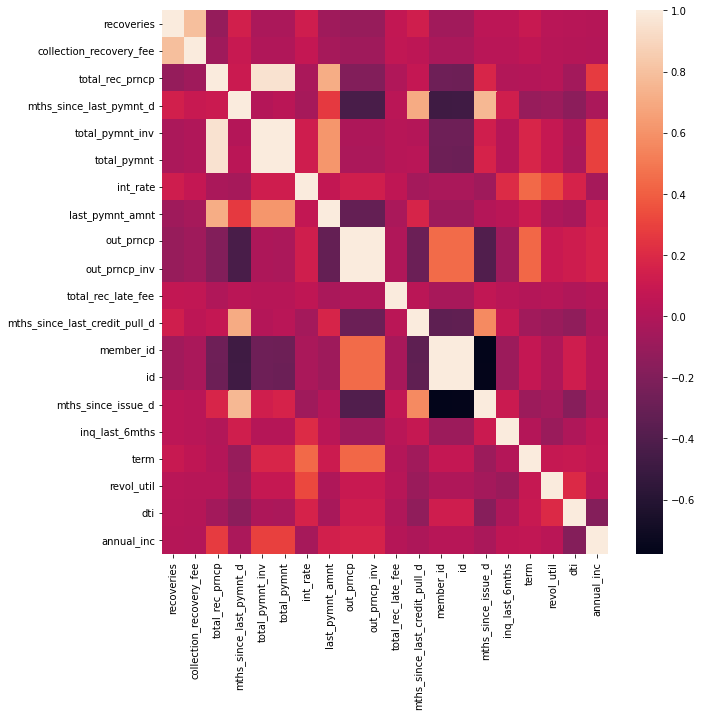

In [29]:
#Se calculan las correlaciones entre ellos
import seaborn as sns
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)


In [30]:
#Se guardan los nombres de las columnas que serán eliminadas en una lista
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])
#Se añade la función para eliminar estas columnas
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)
#Se aplican los cambios a X_train
col_to_drop(X_train, drop_columns_list)